In [1]:
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0 \
 --extra-index-url https://download.pytorch.org/whl/cu121


Defaulting to user installation because normal site-packages is not writeable


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


In [2]:
!pip uninstall numpy -y
!pip install numpy==1.26.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.


In [3]:
!pip install \
    torch-scatter \
    torch-sparse \
    torch-cluster \
    torch-spline-conv \
    -f https://data.pyg.org/whl/torch-2.1.0+cu121.html


Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [4]:
!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.0+cu121
12.1


In [6]:
!pip install open3d tqdm

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


2025-12-25 07:38:52.102118: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-25 07:38:52.145034: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-25 07:38:52.146474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-25 07:38:52.859742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
import os
import glob
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import open3d as o3d


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
# =========================
# CONFIG
# =========================
DATA_DIR = "/home/exouser/02_triangular_mesh_autoencoder/Dataset/FielGrwon_ZeaMays_RawPCD_10k"

NUM_POINTS = 2096
BATCH_SIZE = 2
EPOCHS = 6000
K = 16
LATENT_DIM = 256
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [10]:
def normalize_pc(pts):
    pts = pts - pts.mean(axis=0, keepdims=True)
    scale = np.sqrt((pts ** 2).sum(axis=1)).max()
    return pts / scale


In [11]:
from torch.utils.data import Dataset, DataLoader

class PointCloudDataset(Dataset):
    def __init__(self, data_dir, num_points):
        self.files = sorted(glob.glob(os.path.join(data_dir, "*.ply")))
        self.num_points = num_points

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        pcd = o3d.io.read_point_cloud(self.files[idx])
        pts = np.asarray(pcd.points).astype(np.float32)

        if pts.shape[0] >= self.num_points:
            idxs = np.random.choice(pts.shape[0], self.num_points, replace=False)
            pts = pts[idxs]
        else:
            pad = self.num_points - pts.shape[0]
            pts = np.pad(pts, ((0, pad), (0, 0)), mode='wrap')

        pts = normalize_pc(pts)
        return torch.from_numpy(pts).float()


In [12]:
import glob, os

dataset = PointCloudDataset(DATA_DIR, NUM_POINTS)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [13]:
def knn_graph(x, k):
    with torch.no_grad():
        dist = torch.cdist(x, x)
        idx = dist.topk(k=k+1, largest=False)[1][:, :, 1:]
    return idx


In [14]:
class EdgeConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels * 2, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )

    def forward(self, x):
        idx = knn_graph(x, K)
        B, N, C = x.shape
        K_ = idx.shape[-1]

        idx = idx.unsqueeze(-1).expand(-1, -1, -1, C)
        neighbors = torch.gather(
            x.unsqueeze(1).expand(-1, N, -1, -1),
            2,
            idx
        )

        diff = neighbors - x.unsqueeze(2)
        edge_feat = torch.cat([x.unsqueeze(2).expand(-1, -1, K_, -1), diff], dim=-1)
        out = edge_feat.mean(dim=2)

        return self.mlp(out)


In [15]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.ec1 = EdgeConv(3, 64)
        self.ec2 = EdgeConv(64, 128)
        self.ec3 = EdgeConv(128, 256)
        self.fc = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = self.ec1(x)
        x = self.ec2(x)
        x = self.ec3(x)
        x = x.max(dim=1)[0]
        return self.fc(x)


In [16]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_points):
        super().__init__()
        self.num_points = num_points
        self.point_embed = nn.Parameter(torch.randn(num_points, 64))

        self.mlp = nn.Sequential(
            nn.Linear(latent_dim + 64, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, z):
        B = z.shape[0]
        z = z.unsqueeze(1).repeat(1, self.num_points, 1)
        p = self.point_embed.unsqueeze(0).repeat(B, 1, 1)
        return self.mlp(torch.cat([z, p], dim=-1))


In [17]:
class PointCloudAE(nn.Module):
    def __init__(self, latent_dim, num_points):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, num_points)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z


In [18]:
def chamfer_distance(p1, p2):
    dist = torch.cdist(p1, p2)
    cd = dist.min(dim=2)[0].mean(dim=1) + dist.min(dim=1)[0].mean(dim=1)
    return cd.mean()


In [19]:
model = PointCloudAE(LATENT_DIM, NUM_POINTS).to(DEVICE)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=150,
    gamma=0.3
)


In [ ]:
CHECKPOINT_DIR = "/home/exouser/02_triangular_mesh_autoencoder/checkpoints/GCN_point"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for pts in loader:
        pts = pts.to(DEVICE)

        recon, _ = model(pts)
        loss = chamfer_distance(recon, pts)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(loader)

    print(f"Epoch [{epoch:03d}/{EPOCHS}] | Chamfer: {avg_loss:.6f}")

    # ===== Save checkpoint every 50 epochs =====
    if epoch % 50 == 0:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"gcn_ae_epoch_{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": avg_loss
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")


Epoch [001/6000] | Chamfer: 0.132564
Epoch [002/6000] | Chamfer: 0.108276
Epoch [003/6000] | Chamfer: 0.104909
Epoch [004/6000] | Chamfer: 0.096596
Epoch [005/6000] | Chamfer: 0.090884
Epoch [006/6000] | Chamfer: 0.088058
Epoch [007/6000] | Chamfer: 0.086128
Epoch [008/6000] | Chamfer: 0.084313
Epoch [009/6000] | Chamfer: 0.081352
Epoch [010/6000] | Chamfer: 0.077391
Epoch [011/6000] | Chamfer: 0.075278
Epoch [012/6000] | Chamfer: 0.074297
Epoch [013/6000] | Chamfer: 0.072975
Epoch [014/6000] | Chamfer: 0.072184
Epoch [015/6000] | Chamfer: 0.071224
Epoch [016/6000] | Chamfer: 0.070725
Epoch [017/6000] | Chamfer: 0.069772
Epoch [018/6000] | Chamfer: 0.069237
Epoch [019/6000] | Chamfer: 0.068481
Epoch [020/6000] | Chamfer: 0.067941
Epoch [021/6000] | Chamfer: 0.067005
Epoch [022/6000] | Chamfer: 0.066823
Epoch [023/6000] | Chamfer: 0.065942
Epoch [024/6000] | Chamfer: 0.065824
Epoch [025/6000] | Chamfer: 0.065276
Epoch [026/6000] | Chamfer: 0.064589
Epoch [027/6000] | Chamfer: 0.064014
E

In [20]:
# ============ CONFIG ============
NUM_POINTS = 2096
LATENT_DIM = 256
K = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_DIR = "/home/exouser/02_triangular_mesh_autoencoder/Dataset/FielGrwon_ZeaMays_RawPCD_10k"
CKPT_PATH = "/home/exouser/02_triangular_mesh_autoencoder/checkpoints/GCN_point/gcn_ae_epoch_2000.pth"


In [21]:
def normalize_pc(pts):
    pts = pts - pts.mean(axis=0, keepdims=True)
    scale = np.sqrt((pts ** 2).sum(axis=1)).max()
    return pts / scale


In [22]:
def knn_graph(x, k):
    with torch.no_grad():
        dist = torch.cdist(x, x)
        idx = dist.topk(k=k+1, largest=False)[1][:, :, 1:]
    return idx

class EdgeConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels * 2, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )

    def forward(self, x):
        idx = knn_graph(x, K)
        B, N, C = x.shape
        K_ = idx.shape[-1]

        idx = idx.unsqueeze(-1).expand(-1, -1, -1, C)
        neighbors = torch.gather(
            x.unsqueeze(1).expand(-1, N, -1, -1),
            2,
            idx
        )

        diff = neighbors - x.unsqueeze(2)
        edge_feat = torch.cat([x.unsqueeze(2).expand(-1, -1, K_, -1), diff], dim=-1)
        out = edge_feat.mean(dim=2)

        return self.mlp(out)

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.ec1 = EdgeConv(3, 64)
        self.ec2 = EdgeConv(64, 128)
        self.ec3 = EdgeConv(128, 256)
        self.fc = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = self.ec1(x)
        x = self.ec2(x)
        x = self.ec3(x)
        x = x.max(dim=1)[0]
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, num_points):
        super().__init__()
        self.num_points = num_points
        self.point_embed = nn.Parameter(torch.randn(num_points, 64))

        self.mlp = nn.Sequential(
            nn.Linear(latent_dim + 64, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, z):
        B = z.shape[0]
        z = z.unsqueeze(1).repeat(1, self.num_points, 1)
        p = self.point_embed.unsqueeze(0).repeat(B, 1, 1)
        return self.mlp(torch.cat([z, p], dim=-1))

class PointCloudAE(nn.Module):
    def __init__(self, latent_dim, num_points):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, num_points)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z


In [23]:
model = PointCloudAE(LATENT_DIM, NUM_POINTS).to(DEVICE)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("Checkpoint loaded from epoch:", ckpt["epoch"])


Checkpoint loaded from epoch: 2000


In [24]:
file_path = sorted(glob.glob(os.path.join(DATA_DIR, "*.ply")))[0]

pcd = o3d.io.read_point_cloud(file_path)
pts = np.asarray(pcd.points).astype(np.float32)

if pts.shape[0] >= NUM_POINTS:
    idxs = np.random.choice(pts.shape[0], NUM_POINTS, replace=False)
    pts = pts[idxs]
else:
    pad = NUM_POINTS - pts.shape[0]
    pts = np.pad(pts, ((0, pad), (0, 0)), mode='wrap')

pts = normalize_pc(pts)
input_pts = torch.from_numpy(pts).unsqueeze(0).to(DEVICE)


In [28]:
# ----- Load one sample again -----
file_path = sorted(glob.glob(os.path.join(DATA_DIR, "*.ply")))[0]

pcd = o3d.io.read_point_cloud(file_path)
pts = np.asarray(pcd.points).astype(np.float32)

if pts.shape[0] >= NUM_POINTS:
    idxs = np.random.choice(pts.shape[0], NUM_POINTS, replace=False)
    pts = pts[idxs]
else:
    pad = NUM_POINTS - pts.shape[0]
    pts = np.pad(pts, ((0, pad), (0, 0)), mode='wrap')

pts = normalize_pc(pts)

# Torch tensor for model
input_tensor = torch.from_numpy(pts).unsqueeze(0).to(DEVICE)


In [29]:
with torch.no_grad():
    recon_tensor, z = model(input_tensor)

input_pts_np = input_tensor.squeeze(0).cpu().numpy()
recon_np = recon_tensor.squeeze(0).cpu().numpy()


In [30]:
pcd_gt = o3d.geometry.PointCloud()
pcd_gt.points = o3d.utility.Vector3dVector(input_pts_np)
pcd_gt.paint_uniform_color([1, 0, 0])

pcd_rec = o3d.geometry.PointCloud()
pcd_rec.points = o3d.utility.Vector3dVector(recon_np)
pcd_rec.paint_uniform_color([0, 1, 0])

o3d.visualization.draw_geometries([pcd_gt, pcd_rec])


[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [31]:
save_path = "reconstruction.ply"
o3d.io.write_point_cloud(save_path, pcd_rec)
print("Saved:", save_path)


Saved: reconstruction.ply


In [32]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt


In [36]:
# How many samples to visualize
N_SAMPLES = 1045

latents = []
labels = []   # optional if you later add class labels

model.eval()

files = sorted(glob.glob(os.path.join(DATA_DIR, "*.ply")))[:N_SAMPLES]

for f in tqdm(files):
    pcd = o3d.io.read_point_cloud(f)
    pts = np.asarray(pcd.points).astype(np.float32)

    if pts.shape[0] >= NUM_POINTS:
        idxs = np.random.choice(pts.shape[0], NUM_POINTS, replace=False)
        pts = pts[idxs]
    else:
        pad = NUM_POINTS - pts.shape[0]
        pts = np.pad(pts, ((0, pad), (0, 0)), mode='wrap')

    pts = normalize_pc(pts)
    x = torch.from_numpy(pts).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        _, z = model(x)

    latents.append(z.squeeze(0).cpu().numpy())

latents = np.array(latents)
print("Latent matrix:", latents.shape)


100%|██████████| 1045/1045 [00:03<00:00, 284.02it/s]

Latent matrix: (1045, 256)


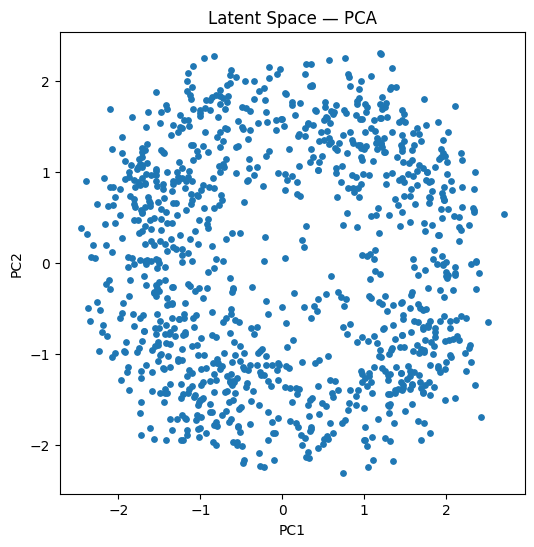

In [37]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(latents)

plt.figure(figsize=(6,6))
plt.scatter(z_pca[:,0], z_pca[:,1], s=15)
plt.title("Latent Space — PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


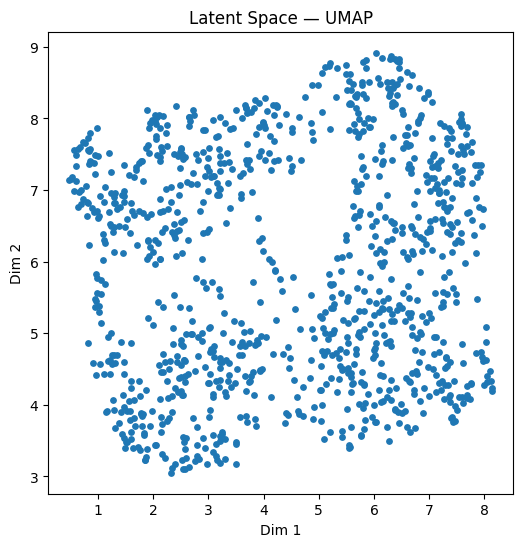

In [38]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
z_umap = reducer.fit_transform(latents)

plt.figure(figsize=(6,6))
plt.scatter(z_umap[:,0], z_umap[:,1], s=15)
plt.title("Latent Space — UMAP")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


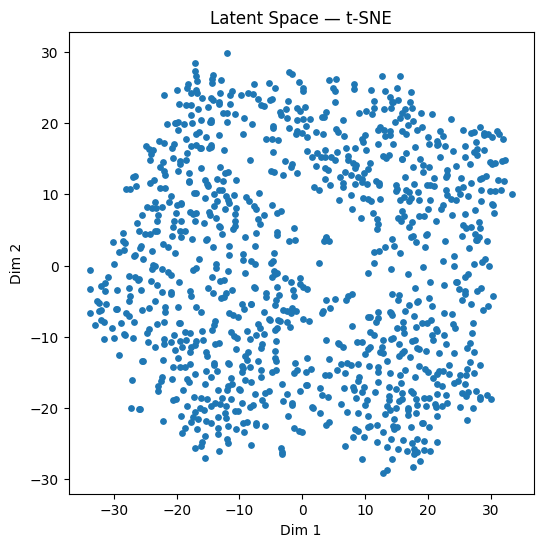

In [39]:
tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto")
z_tsne = tsne.fit_transform(latents)

plt.figure(figsize=(6,6))
plt.scatter(z_tsne[:,0], z_tsne[:,1], s=15)
plt.title("Latent Space — t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()
